In [4]:
from bessel import bessel_roots, J_lx
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import numba as nb

## First step   
Compute the roots of the spherical bessel-functions $j_l(x)$, l $\in$ [0,...,100] and x $\in$ [0,...,100].  
Here we compare the found roots of the bessel functions to the roots when calculating the bessel functions with scipy

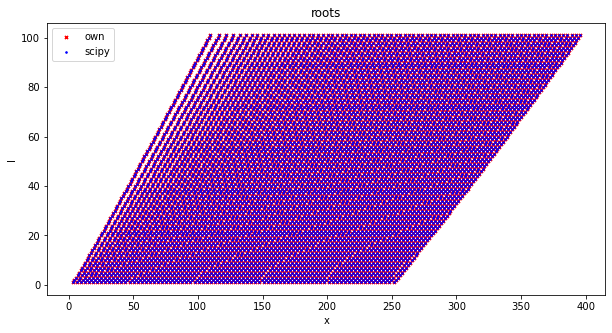

In [5]:
n_roots = 80 # index i 
l_max = 100
roots_li = bessel_roots(l_max, n_roots,scipy = False)
plt.figure(figsize=(10,5))
plot_mat = np.ones((l_max+1,n_roots))
for i in range(l_max+1):
    plot_mat[i,:] *= (i+1)

plt.scatter(roots_li,plot_mat,marker = 'x',color = 'r',s = 10)
plt.scatter(bessel_roots(l_max, n_roots,scipy = True),plot_mat,marker = '.',color = 'b',s = 10)
plt.xlabel("x")
plt.ylabel("l")
plt.title("roots")
plt.legend(["own","scipy"])

In [6]:
roots_li

array([[  3.14159265,   6.28318531,   9.42477796, ..., 245.04422698,
        248.18581963, 251.32741229],
       [  4.49340946,   7.72525184,  10.90412166, ..., 246.61096836,
        249.75261202, 252.89425441],
       [  5.7634592 ,   9.09501133,  12.32294097, ..., 248.17373133,
        251.3154751 , 254.45721514],
       ...,
       [107.29400298, 114.16708542, 119.97933133, ..., 386.3572033 ,
        389.60521104, 392.85137086],
       [108.32215748, 115.21533964, 121.04343162, ..., 387.71448819,
        390.96398523, 394.21161283],
       [109.35012893, 116.26328665, 122.10713097, ..., 389.07059996,
        392.32158843, 395.57068597]])

In [7]:
# R = 10 fm
R  = 20 * 1e-15
#now we want to calculate the wavenumbers. we know the relation between the wavenumber and the roots of the bessel function
# j_l(k_il R) = 0.
k_il = roots_li.T / R

### Look at bessel functions

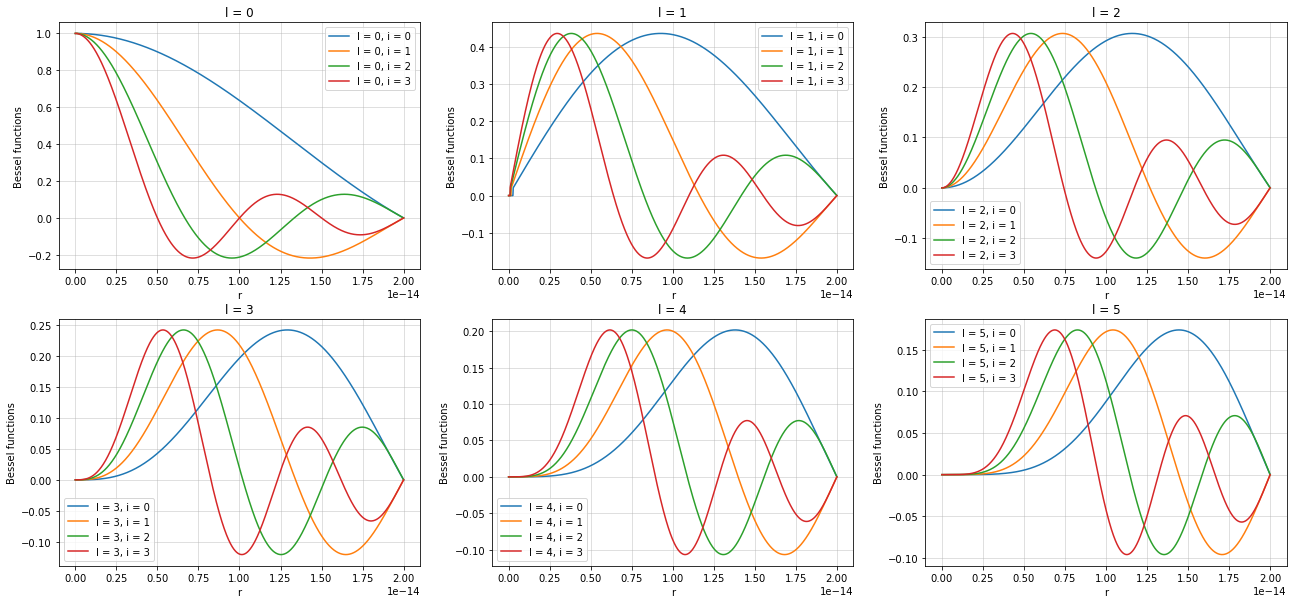

In [8]:
r = np.linspace(0,R,1000)
l_max = 6
i_max = 4   # ~ n_roots

fig, ax = plt.subplots(int(np.ceil(l_max/3)),3,figsize = (22, 5*int(np.ceil(l_max/3))))
fig.set_facecolor('white')
ax = ax.flatten()
for l in range(l_max):
    for i in range(i_max):
        ax[l].plot(r,np.vectorize(J_lx)(l,k_il[i,l] * r),label = "l = {}, i = {}".format(l,i))
        ax[l].set_xlabel("r")
        ax[l].set_ylabel("Bessel functions")
        ax[l].legend()
        ax[l].set_title("l = {}".format(l))
        ax[l].grid(alpha=0.5)

### Look at the $\delta_{ij}$ nature, j=0

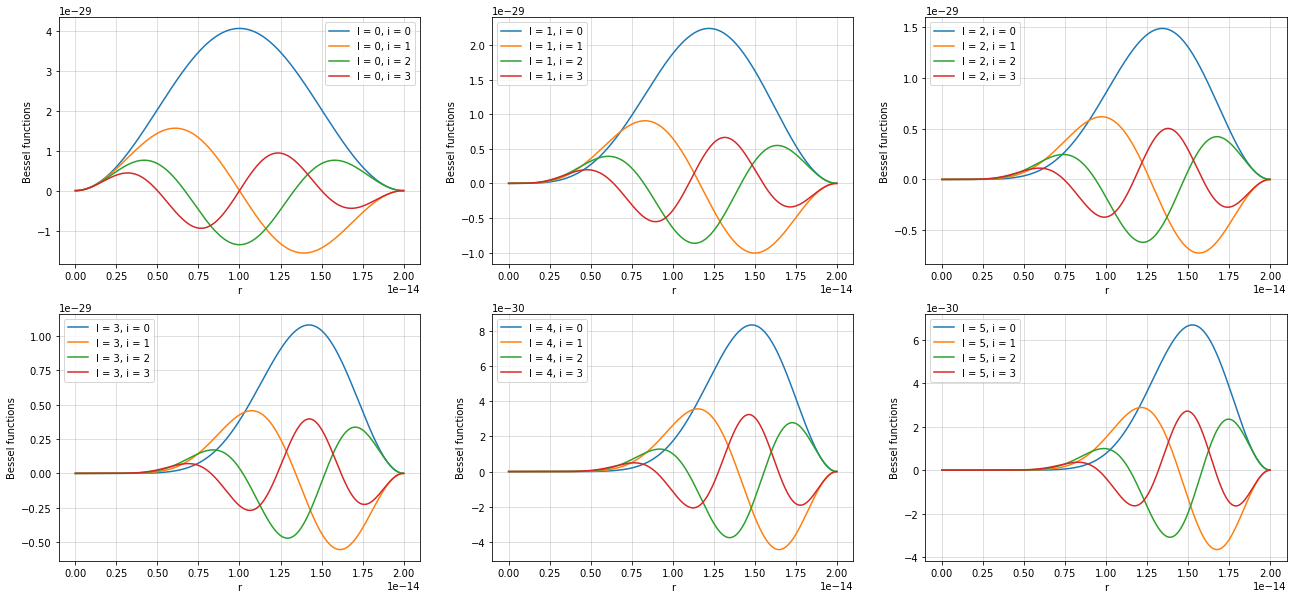

In [9]:
r = np.linspace(0,R,1000)
l_max = 6
i_max = 4

fig, ax = plt.subplots(int(np.ceil(l_max/3)),3,figsize = (22, 5*int(np.ceil(l_max/3))))
fig.set_facecolor('white')
ax = ax.flatten()
for l in range(l_max):
    for i in range(i_max):
        ax[l].plot(r,np.vectorize(J_lx)(l,k_il[0,l] * r)*np.vectorize(J_lx)(l,k_il[i,l] * r)*r**2,label = "l = {}, i = {}".format(l,i))
        ax[l].set_xlabel("r")
        ax[l].set_ylabel("Bessel functions")
        ax[l].legend()
        ax[l].grid(alpha=0.5)

In [10]:
#now we want to check the orthogonality of the spherical bessel functions
#we want to calculate the integral of j_l(k_il R) * j_l(k_il R) * r^2 dr from 0 to R
#for this we use the trapezoidal rule
#@nb.njit
#func(r,i=1,j=1,l=1) = y
def trapz(func: callable, a, b, N: int ):
    dr = (b-a)/N
    r_i = a + np.arange(0,N) * dr
    return (0.5 * func(a) + np.sum(func(r_i)) + 0.5 * func(b)) * dr
#@nb.njit
def trapz2(func: callable, a, b, N: int ):
    "trapzoidal rule with for loops"
    dr = (b-a)/N
    r_i = a + np.arange(0,N) * dr
    integral = 0
    for i in range(1,N):
        integral += func(r_i[i])
    return (0.5 * func(a) + integral + 0.5 * func(b)) * dr
    
    
#now we test it with a known function
@nb.njit
def f(x):
    return np.sin(x)
print(trapz(f,0,np.pi,200))
print(trapz2(f,0,np.pi,200))
#the known integral is 2


1.9999588764792147
1.9999588764792162


Now we want to check the orthonormality of the spherical bessel-functions. We use the following integral:
$$
\int_0^R j_l(k_{li} r) j_l(k_{lj} r) r^2 dr = \delta_{ij} \frac{1}{\alpha_{ij}^2}
$$
with $\alpha_{ij} = \frac{1}{j_{l-1}(k_{jl R})} \cdot \sqrt{2/R^3}$



In [11]:
@nb.jit(nopython=True)
def integrand(r,i,j,l):
    "define the integrand for the orthogonality of the spherical bessel functions"
    if r == 0:
        return 0
    else:
        return J_lx(l,k_il[i,l] * r) * J_lx(l,k_il[j,l] * r) * r**2

#scipy implementation
def integrand2(r,i,j,l):
    "define the integrand for the orthogonality of the spherical bessel functions with scipy.special"
    if r == 0:
        return 0
    return sp.spherical_jn(l,k_il[i,l] * r) * sp.spherical_jn(l,k_il[j,l] * r) * r**2

#now we want to calculate the integral for different l and j
#we want to store the results in a matrix

def create_integration_matrix(l_max,n_roots,scipy = False):
    "creates a matrix with the integrals of the spherical bessel functions defined above for every l and j"
    integral_lij = np.zeros((l_max,n_roots,n_roots))
    if not scipy:
        for l in range(l_max):
            for i in range(n_roots):
                for j in range(n_roots):
                    @np.vectorize
                    def func2(r):
                        return integrand(r,i,j,l)
                    integral_lij[l,i,j] = trapz(func2,0,R,1000)
        return integral_lij
    
    else:
        for l in range(l_max):
            for i in range(n_roots):
                for j in range(n_roots):
                    @np.vectorize
                    def func2(r):
                        return integrand2(r,i,j,l)
                    integral_lij[l,i,j] = trapz2(func2,0,R,1000)
        return integral_lij
    

print(create_integration_matrix(2,2,scipy = False))
print(create_integration_matrix(2,2,scipy = True))

[[[ 4.05284749e-43  8.19720199e-51]
  [ 8.19720199e-51  1.01321185e-43]]

 [[ 1.88761795e-43 -2.75167542e-51]
  [-2.75167542e-51  6.59201037e-44]]]
[[[4.05284735e-43 2.38507259e-60]
  [2.38507259e-60 1.01321184e-43]]

 [[1.88761797e-43 8.85968097e-59]
  [8.85968097e-59 6.59201040e-44]]]


In [12]:
#now we want to calculate the alpha matrix
def calculate_alpha_matrix(n_roots,l_max, scipy = False):
    "calculates the alpha matrix for every l and j"
    alpha_ij = np.zeros((n_roots,l_max))
    for i in range(0,n_roots):
        alpha_ij[i,0] =  np.sqrt(2/R**3) * (i +1) * np.pi
    for l in range(1,l_max):
        for i in range(0,n_roots):
            if not scipy:
                alpha_ij[i,l] = 1 / J_lx(l-1,k_il[i,l] * R) * np.sqrt(2/R**3)
            else:
                alpha_ij[i,l] = 1/ sp.spherical_jn(l-1,k_il[i,l] * R) * np.sqrt(2/R**3)
    return alpha_ij
print(calculate_alpha_matrix(2,2,scipy = True)**-2)
print(calculate_alpha_matrix(2,2,scipy = False)**-2)


[[4.05284735e-43 1.88761797e-43]
 [1.01321184e-43 6.59201040e-44]]
[[4.05284735e-43 1.88761797e-43]
 [1.01321184e-43 6.59201040e-44]]


1.3) Now we want to diagonolize the matrix $A_{ij}$ = (i+j)/2 for N = 3,10,100 with the jacobi method.


In [13]:
from jacobi_routine import jacobi_diagonalization, Jacobi
from scipy.linalg import eigvalsh

#jacobi_diagonalization = nb.njit(jacobi_diagonalization)

N = 20
def A_entry(i,j):
    return (i+j)/2
index_list = np.arange(1,N+1)
A = A_entry(index_list[:,None],index_list[None,:])


eigvals_jacobi = jacobi_diagonalization(A)[0]
eigvals_scipy = eigvalsh(A)
jac_routine = Jacobi(A)
jac_routine.jacobi_diagonalization()
eigvals_numerical_recipes = jac_routine.d



print(np.isclose(np.sort(eigvals_jacobi),np.sort(eigvals_scipy)))
print(np.isclose(np.sort(eigvals_scipy),np.sort(eigvals_numerical_recipes)))


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


The easier jacobi method is failing for N> 27. The more advanced jacobi method from the numerical recipes book can handle bigger matricies easily.

1.4) Solve the schrödinger equation for the movement of a nucleus in an atomic nucleus. The radius of the box R = 10-20 fm. The mass of the nucleus is 939 MeV/c^2.

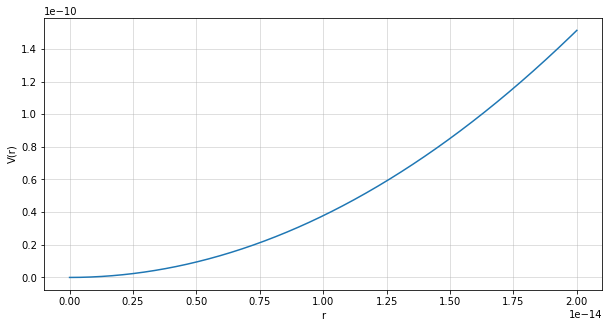

In [38]:
#The potential is given as V(r) = 1/2 * m * omega^2 * r^2 with hw = 14 eV
eV = 1.602176634e-19 #J
c = 299792458 #m/s
h_bar = 6.582119569e-16 * eV #eV*s 

@nb.jit(nopython=True)
def V(r):
    M = 938.2720813* 1e6 * eV / c**2
    omega = 14 *1e6 * eV / h_bar
    return 0.5 * omega**2 * r**2 * M
# now we want to calculate  the matrix elements of the hamilton with the given potential.
#H_mn = <m|H|n> = <m|T|n> + <m|V|n>
#we know that <m|T|n> = 0 if m != n
#and <m|T|n> = <i'l'm'|T|ilm> = d_ii' d_ll' d_mm' (h_q*c)^2/(2Mc^2)k_il^2 
# first we calculate the matrix elements of the kinetic energy


c = 299792458 #m/s
M = 938.2720813* 1e6 * eV / c**2

r = np.linspace(0,R,1000)
harm_oszi_potential = np.vectorize(V)(r)

fig, ax = plt.subplots(1,1,figsize = (10, 5))
fig.set_facecolor('white')
ax.plot(r,harm_oszi_potential)
ax.set_xlabel("r")
ax.set_ylabel("V(r)")
ax.grid(alpha=0.5)


In [52]:
r_0 = 10 * 1e-15 #m
@nb.njit
def integrand_scipy(r,i,i_bar,l):
    return sp.spherical_jn(l,k_il[i_bar,l] * r) * sp.spherical_jn(l,k_il[i,l] * r) * r**2 *V(r)

@nb.njit
def integrand_V(r,i,i_bar,l):
    return J_lx(l,k_il[i_bar,l] * r) * J_lx(l,k_il[i,l] * r) * r**2 *V(r)

def length_matrix(l_max):
    n_matricies = 0
    for l in range(l_max+1):
        n_matricies += (2*l + 1)
    return n_matricies

@nb.jit(nopython=True)
def calculate_alpha(j,l):
    if l == 0:
        return np.sqrt(2/R**3) * (j+1) * np.pi
    else:
        return 1 / J_lx(l-1,k_il[j,l] * R) * np.sqrt(2/R**3)

def calculate_single_V(l,n_roots):
    matrix = np.zeros((n_roots,n_roots))
    alpha_ii_bar = calculate_alpha_matrix(n_roots,l+1) 
    for i in range(n_roots):
        for i_bar in range(n_roots):
            @np.vectorize
            def integrand(r):
                return integrand_V(r,i,i_bar,l)
            matrix[i,i_bar] = trapz(integrand,0,R,200) * calculate_alpha(i,l) * calculate_alpha(i_bar,l)
    return matrix

@nb.jit(nopython=True)
def calculate_single_T(l,n_roots):
    matrix = np.zeros((n_roots,n_roots))
    for i in range(n_roots):
        matrix[i,i] = h_bar**2 / (2 * M ) * k_il[i,l]**2 
    return matrix

def calculate_single_H(l,n_roots):
    return calculate_single_T(l,n_roots) + calculate_single_V(l,n_roots)

def calc_evs(l,n_roots):
    # jac_routine = Jacobi(calculate_single_T(l,n_roots) + calculate_single_V(l,n_roots))
    jac_routine = Jacobi(calculate_single_H(l,n_roots))
    jac_routine.jacobi_diagonalization()
    return jac_routine.d

def numpy_eigvals(l,n_roots):
    return np.linalg.eig(calculate_single_H(l,n_roots))[0]

def numpy_eigvecs(l,n_roots):
    return np.linalg.eig(calculate_single_H(l,n_roots))[1]


(30, 60)
(0, 15)


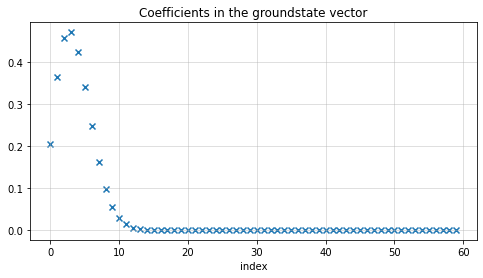

In [53]:
from joblib import Parallel, delayed
import multiprocessing

l_max = 30
n_roots = 60

num_cores = multiprocessing.cpu_count()
# evs = Parallel(n_jobs=num_cores)(delayed(calc_evs)(l,n_roots) for l in range(l_max))

# horribly inefficient, just didnt know how to use it with Parallel
np_eigvals = np.array(Parallel(n_jobs=num_cores)(delayed(numpy_eigvals)(l, n_roots) for l in range(l_max)))
np_eigvecs = np.array(Parallel(n_jobs=num_cores)(delayed(numpy_eigvecs)(l, n_roots) for l in range(l_max)))
argmin_eigvals = np.unravel_index(np.argmin(np_eigvals), np_eigvals.shape)
print(np_eigvals.shape)
print(argmin_eigvals)
eigvec_groundstate = np_eigvecs[argmin_eigvals[0],:,argmin_eigvals[1]]
l = argmin_eigvals[0]
# eigvec_groundstate = np_eigvecs[10,:,10]
# print(eigvec_groundstate)

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.scatter(np.arange(0,n_roots),eigvec_groundstate, marker="x")
ax.set_title("Coefficients in the groundstate vector")      # l = argmin_eigvals[0] ~ usually 0 - makes sense
ax.set_xlabel("index")
ax.grid(alpha=0.5)


### Plotting the wavefunctions for the N smallest eigenvalues

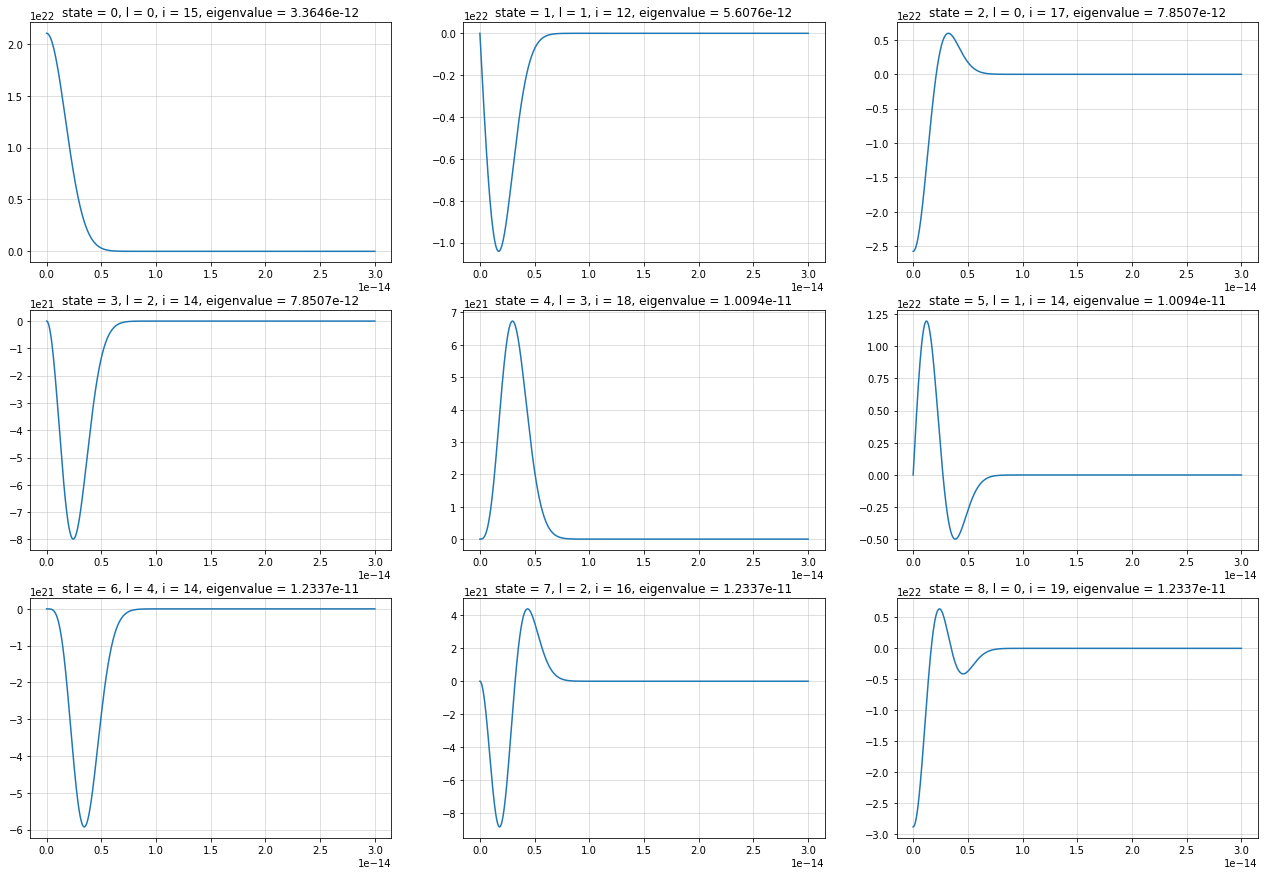

In [54]:
r = np.linspace(0,1.5*R,1000)
l = 0

N = 9
indices_flat = np.argpartition(np_eigvals.flatten(), N)[:N]
sorted_indices = indices_flat[np.argsort(np_eigvals.flatten()[indices_flat])]
indices_tuples = np.unravel_index(sorted_indices, np_eigvals.shape)

fig, ax = plt.subplots(int(np.ceil(N/3)),3,figsize = (22,5*int(np.ceil(N/3))))
fig.set_facecolor('white')
for n, (row,column) in enumerate(zip(*indices_tuples)):
    # row ~ l
    l = row
    state = np_eigvecs[row,:,column]
    wavefunction = np.zeros(len(r))
    ax = ax.flatten()
    for i in range(n_roots):
        alpha = calculate_alpha(i,l)
        spherical = sp.spherical_jn(l,k_il[i,l] * r)
        basis_func = spherical * alpha  # * spherical harmonics, which do not depend on r
        wavefunction += basis_func * state[i]
    ax[n].plot(r, wavefunction)
    ax[n].grid(alpha=0.5)
    ax[n].set_title(f"state = {n}, l = {row}, i = {column}, eigenvalue = " + "{:.4e}".format(np_eigvals[row,column]))



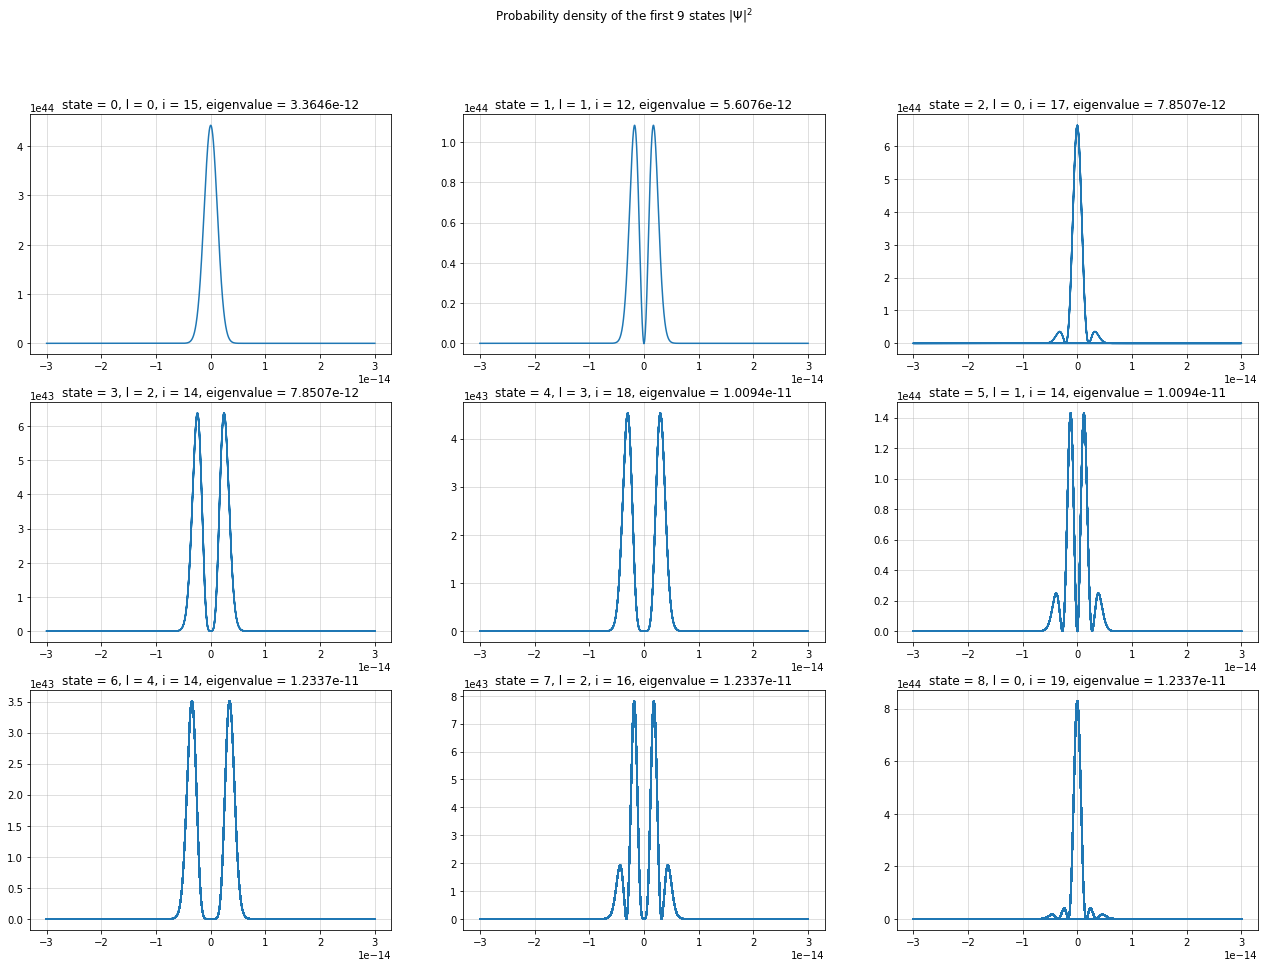

In [55]:
fig, ax = plt.subplots(int(np.ceil(N/3)),3,figsize = (22,5*int(np.ceil(N/3))))
fig.set_facecolor('white')
fig.suptitle(f"Probability density of the first {N} states " + "$|\\Psi|^2$")
for n, (row,column) in enumerate(zip(*indices_tuples)):
    # row ~ l
    l = row
    state = np_eigvecs[row,:,column]
    wavefunction = np.zeros(len(r))
    ax = ax.flatten()
    for i in range(n_roots):
        alpha = calculate_alpha(i,l)
        spherical = sp.spherical_jn(l,k_il[i,l] * r)
        basis_func = spherical * alpha  # * spherical harmonics, which do not depend on r
        wavefunction += basis_func * state[i]
    wavefunction = np.concatenate((wavefunction[::-1], wavefunction[1:]))
    r = np.concatenate((-r[::-1], r[1:]))
    ax[n].plot(r, np.abs(wavefunction)**2)
    ax[n].grid(alpha=0.5)
    ax[n].set_title(f"state = {n}, l = {row}, i = {column}, eigenvalue = " + "{:.4e}".format(np_eigvals[row,column]))


(array([ 0,  1,  0,  2,  3,  1,  4,  2,  0,  1,  3,  5,  0,  2,  4,  6,  5,
        3,  7,  1,  8,  4,  6,  2,  0,  1,  5,  7,  3,  9,  0,  2,  4, 10,
        8,  6,  5,  3,  7, 11,  9,  1, 12,  4, 10,  6,  8,  2,  0,  1],
      dtype=int64), array([15, 12, 17, 14, 18, 14, 14, 16, 19, 16, 20, 20, 22, 17, 16, 20, 22,
       21, 16, 18, 16, 18, 22, 18, 24, 19, 24, 18, 23, 18, 25, 20, 20, 22,
       18, 24, 25, 24, 20, 17, 20, 21, 19, 21, 24, 26, 19, 22, 26, 23],
      dtype=int64))


Text(0.5, 1.0, 'state = 49, eigenvalue = 3.2524e-11')

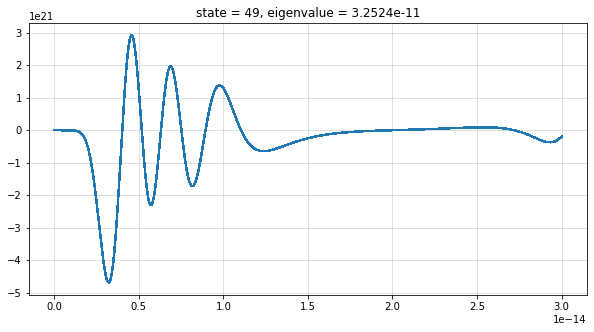

In [56]:
N = 50
l = 10
indices_flat = np.argpartition(np_eigvals.flatten(), N)[:N]
sorted_indices = indices_flat[np.argsort(np_eigvals.flatten()[indices_flat])]
indices_tuples = np.unravel_index(sorted_indices, np_eigvals.shape)
print(indices_tuples)

fig, ax = plt.subplots(1,1,figsize = (10,5))
fig.set_facecolor('white')
row = indices_tuples[0][-1]
column = indices_tuples[1][-1]

state = np_eigvecs[row,:,column]
wavefunction = np.zeros(len(r))
for i in range(n_roots):
    alpha = calculate_alpha(i,l)
    spherical = sp.spherical_jn(l,k_il[i,l] * r)
    basis_func = spherical * alpha  # * spherical harmonics, which do not depend on r
    wavefunction += basis_func * state[i]
ax.plot(r, wavefunction)
ax.grid(alpha=0.5)
ax.set_title(f"state = {N-1}, eigenvalue = " + "{:.4e}".format(np_eigvals[row,column]))

In [20]:
evs_ln = np.array(evs)
print(evs_ln.shape)
#every row is a l and every column is the n_th eigenvalue
print("l = 0 first 3 eigenvalues\n",evs_ln[0,:3])


NameError: name 'evs' is not defined

In [ ]:
exact_ev = np.zeros((l_max,n_roots))
eV = 1.602176634e-19
for l in range(l_max):
    for n in range(n_roots):
        exact_ev[l,n] = (2 * n + l + 3/2) * 14 * 1e6 * eV
ev_exact_sorted = np.sort(exact_ev,axis = 1)        #[::-1]
evs_sorted = np.sort(evs,axis = 1,)     #[::-1]
np_eigvals_sorted = np.sort(np_eigvals,axis = 1)     #[::-1]


In [ ]:
print("n = 0 first 9 eigenvalues\n",evs_sorted[:9,0])
print("n = 0 first 9 exact eigenvalues\n",ev_exact_sorted[:9,0])
print("n = 0 first 9 numpy eigenvalues\n",np_eigvals_sorted[:9,0])


n = 0 first 9 eigenvalues
 [3.36457093e-12 5.60761822e-12 7.85066551e-12 1.00937128e-11
 1.23367601e-11 1.45798074e-11 1.68228547e-11 1.90659019e-11
 2.13089492e-11]
n = 0 first 9 exact eigenvalues
 [3.36457093e-12 5.60761822e-12 7.85066551e-12 1.00937128e-11
 1.23367601e-11 1.45798074e-11 1.68228547e-11 1.90659019e-11
 2.13089492e-11]
n = 0 first 9 numpy eigenvalues
 [3.36457093e-12 5.60761822e-12 7.85066551e-12 1.00937128e-11
 1.23367601e-11 1.45798074e-11 1.68228547e-11 1.90659019e-11
 2.13089492e-11]


In [57]:
@nb.jit(nopython=True)
def V_woods_saxon(r,R_0 = 3 * 1e-15):
    "returns the potential for a woods saxon potential with a = 1 fm and V_0 = 50 MeV"
    a = 0.5 * 1e-15 #fm
    V_0 = - 40 * 1e6 *eV #eV
    return V_0 / (1 + np.exp((r - R_0)/a))

r_0 = 10 * 1e-15 #m
@nb.njit
def integrand_scipy(r,i,i_bar,l):
    return sp.spherical_jn(l,k_il[i_bar,l] * r) * sp.spherical_jn(l,k_il[i,l] * r) * r**2 *V_woods_saxon(r)

@nb.njit
def integrand_V(r,i,i_bar,l):
    return J_lx(l,k_il[i_bar,l] * r) * J_lx(l,k_il[i,l] * r) * r**2 *V_woods_saxon(r)


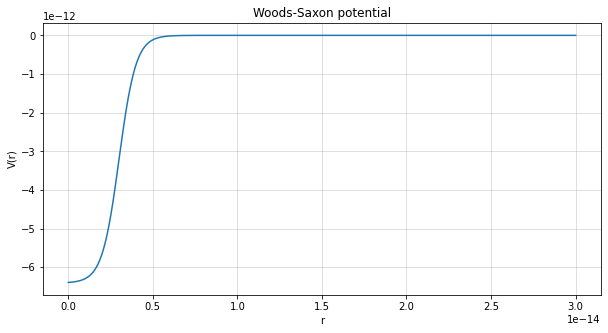

In [62]:
R0 = 3*1e-15
r = np.linspace(0, 1.5*R, 1000)

potential_woods_saxon = np.vectorize(V_woods_saxon)(r,R_0 = 3 * 1e-15)
fig, ax = plt.subplots(1,1,figsize = (10,5))
fig.set_facecolor('white')
ax.plot(r,potential_woods_saxon)
ax.set_xlabel("r")
ax.set_ylabel("V(r)")
ax.set_title("Woods-Saxon potential")
ax.grid(alpha=0.5)


(30, 60)
(0, 42)


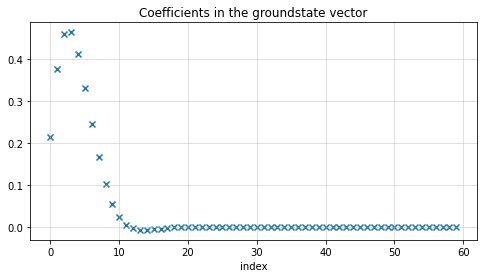

In [60]:
from joblib import Parallel, delayed
import multiprocessing

l_max = 30
n_roots = 60

num_cores = multiprocessing.cpu_count()
# evs = Parallel(n_jobs=num_cores)(delayed(calc_evs)(l,n_roots) for l in range(l_max))

# horribly inefficient, just didnt know how to use it with Parallel
np_eigvals = np.array(Parallel(n_jobs=num_cores)(delayed(numpy_eigvals)(l, n_roots) for l in range(l_max)))
np_eigvecs = np.array(Parallel(n_jobs=num_cores)(delayed(numpy_eigvecs)(l, n_roots) for l in range(l_max)))
argmin_eigvals = np.unravel_index(np.argmin(np_eigvals), np_eigvals.shape)
print(np_eigvals.shape)
print(argmin_eigvals)
eigvec_groundstate = np_eigvecs[argmin_eigvals[0],:,argmin_eigvals[1]]
l = argmin_eigvals[0]
# eigvec_groundstate = np_eigvecs[10,:,10]
# print(eigvec_groundstate)

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.scatter(np.arange(0,n_roots),eigvec_groundstate, marker="x")
ax.set_title("Coefficients in the groundstate vector")      # l = argmin_eigvals[0] ~ usually 0 - makes sense
ax.set_xlabel("index")
ax.grid(alpha=0.5)

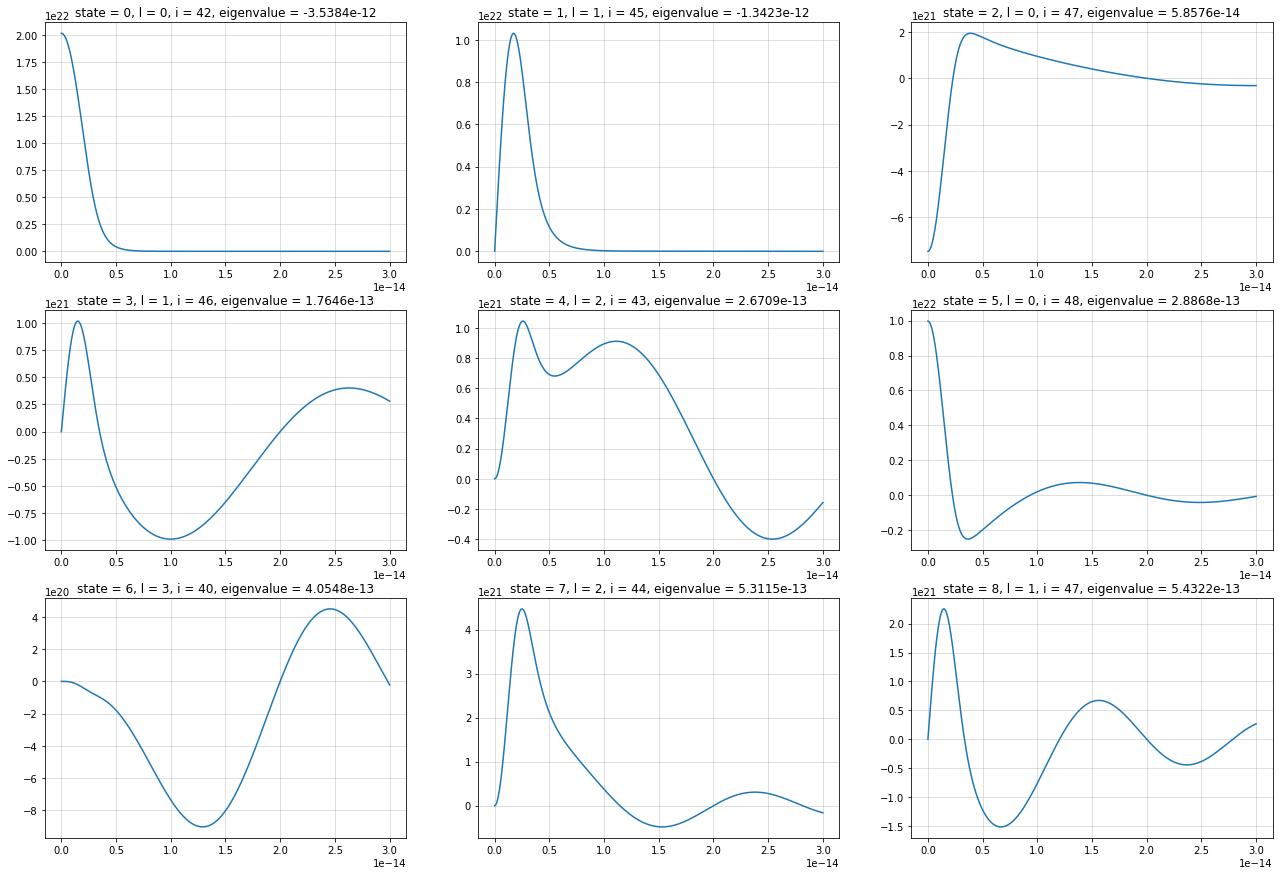

In [63]:
r = np.linspace(0,1.5*R,1000)
l = 0

N = 9
indices_flat = np.argpartition(np_eigvals.flatten(), N)[:N]
sorted_indices = indices_flat[np.argsort(np_eigvals.flatten()[indices_flat])]
indices_tuples = np.unravel_index(sorted_indices, np_eigvals.shape)

fig, ax = plt.subplots(int(np.ceil(N/3)),3,figsize = (22,5*int(np.ceil(N/3))))
fig.set_facecolor('white')
for n, (row,column) in enumerate(zip(*indices_tuples)):
    # row ~ l
    l = row
    state = np_eigvecs[row,:,column]
    wavefunction = np.zeros(len(r))
    ax = ax.flatten()
    for i in range(n_roots):
        alpha = calculate_alpha(i,l)
        spherical = sp.spherical_jn(l,k_il[i,l] * r)
        basis_func = spherical * alpha  # * spherical harmonics, which do not depend on r
        wavefunction += basis_func * state[i]
    ax[n].plot(r, wavefunction)
    ax[n].grid(alpha=0.5)
    ax[n].set_title(f"state = {n}, l = {row}, i = {column}, eigenvalue = " + "{:.4e}".format(np_eigvals[row,column]))

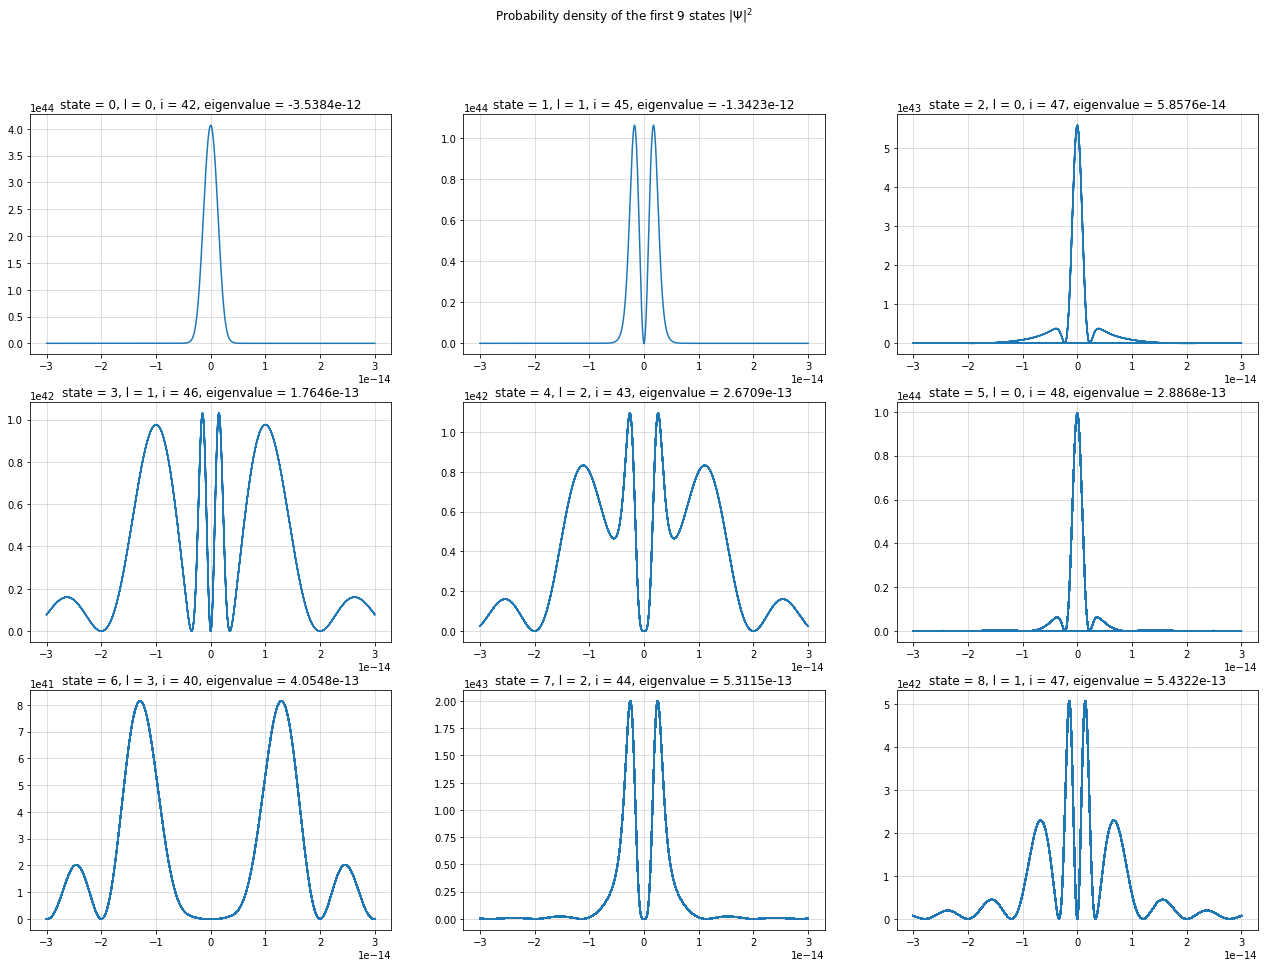

In [64]:
fig, ax = plt.subplots(int(np.ceil(N/3)),3,figsize = (22,5*int(np.ceil(N/3))))
fig.set_facecolor('white')
fig.suptitle(f"Probability density of the first {N} states " + "$|\\Psi|^2$")
for n, (row,column) in enumerate(zip(*indices_tuples)):
    # row ~ l
    l = row
    state = np_eigvecs[row,:,column]
    wavefunction = np.zeros(len(r))
    ax = ax.flatten()
    for i in range(n_roots):
        alpha = calculate_alpha(i,l)
        spherical = sp.spherical_jn(l,k_il[i,l] * r)
        basis_func = spherical * alpha  # * spherical harmonics, which do not depend on r
        wavefunction += basis_func * state[i]
    wavefunction = np.concatenate((wavefunction[::-1], wavefunction[1:]))
    r = np.concatenate((-r[::-1], r[1:]))
    ax[n].plot(r, np.abs(wavefunction)**2)
    ax[n].grid(alpha=0.5)
    ax[n].set_title(f"state = {n}, l = {row}, i = {column}, eigenvalue = " + "{:.4e}".format(np_eigvals[row,column]))